In [1]:
import pandas as pd 
import numpy as np
import json

import os
from collections import Counter

# Append the entire repo parent director so files therein can be accessed in notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent))

from src import helper
%load_ext autoreload

In [2]:
os.listdir('../data/interim/')

['State_time_series.csv',
 'county-time-series-with-fipsmap.pickle',
 'City_time_series.csv',
 'CountyCrossWalk_Zillow.csv',
 'cities_crosswalk.csv',
 'Metro_time_series.csv',
 'fips-county-metro-state-df.pickle',
 'Zip_time_series.csv',
 'County_time_series.csv',
 'Neighborhood_time_series.csv',
 'fips_map.pickle',
 'fips-map.pickle']

### Zip Code time series

In [7]:
zip_ts = pd.read_csv('../data/raw/unzipped/Zip_time_series.csv/Zip_time_series.csv')
zip_ts.head(3)

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
0,1996-04-30,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68700.0,67000.0,101900.0,107000.0,124800.0,NaN,NaN,NaN,NaN,NaN
1,1996-04-30,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97000.0,81300.0,135200.0,145800.0,213600.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85400.0,NaN,101200.0,101200.0,125700.0,NaN,NaN,NaN,NaN,NaN


In [6]:
fips_map = pd.read_pickle('../data/interim/fips_map.pickle')
fips_map.head()

,RegionName,MetroName,StateName,CensusRegion,Unique_City_ID,City,County,State
0,10001,"Dover, DE",Delaware,South,highland_acreskentde,Highland Acres,Kent,DE
1,10001,"Dover, DE",Delaware,South,kentonkentde,Kenton,Kent,DE
2,10001,"Dover, DE",Delaware,South,farmingtonkentde,Farmington,Kent,DE
3,10001,"Dover, DE",Delaware,South,camdenkentde,Camden,Kent,DE
4,10001,"Dover, DE",Delaware,South,feltonkentde,Felton,Kent,DE


#### CountyCrossWalk_Zillow
- not obvious what CBSACode is for
- FIPS is a concatenation of StateFIPS and CountyFIPS together
    - if CountyFIPS is 2 digits then there's a leading 0
    - StateFIPS is only 2 digits long

In [7]:
county_xwalk = pd.read_csv('../data/interim/CountyCrossWalk_Zillow.csv')
county_xwalk.shape

(3144, 10)

In [8]:
county_xwalk.head(3)

,CountyName,StateName,StateFIPS,CountyFIPS,MetroName_Zillow,CBSAName,CountyRegionID_Zillow,MetroRegionID_Zillow,FIPS,CBSACode
0,Pike,Pennsylvania,42,103,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",280,394913.0,42103,35620.0
1,Bronx,New York,36,5,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",401,394913.0,36005,35620.0
2,Essex,New Jersey,34,13,"New York, NY","New York-Newark-Jersey City, NY-NJ-PA",504,394913.0,34013,35620.0


**Figuring out which column from county_xwalk maps over to county_ts**
- FIPS is the common column b/t the 2 dataframes that we can join on
- FIPS will allow us to access the County name, State, etc. in the `county_xwalk` DataFrame which does not appear in the `county_ts` DataFrame

In [9]:
xwalk_countyFIPS = county_xwalk['CountyFIPS'].unique().tolist()
xwalk_countyRegionID = county_xwalk['CountyRegionID_Zillow'].unique().tolist()
xwalk_Metro = county_xwalk['MetroRegionID_Zillow'].unique().tolist()
xwalk_FIPS = county_xwalk['FIPS'].unique().tolist()
xwalk_CBSACode = county_xwalk['CBSACode'].unique().tolist()

print(county_ts['RegionName'].isin(xwalk_countyFIPS).sum())
print(county_ts['RegionName'].isin(xwalk_countyRegionID).sum())
print(county_ts['RegionName'].isin(xwalk_Metro).sum())
print(county_ts['RegionName'].isin(xwalk_FIPS).sum())
print(county_ts['RegionName'].isin(xwalk_CBSACode).sum())

0
9603
0
518791
0


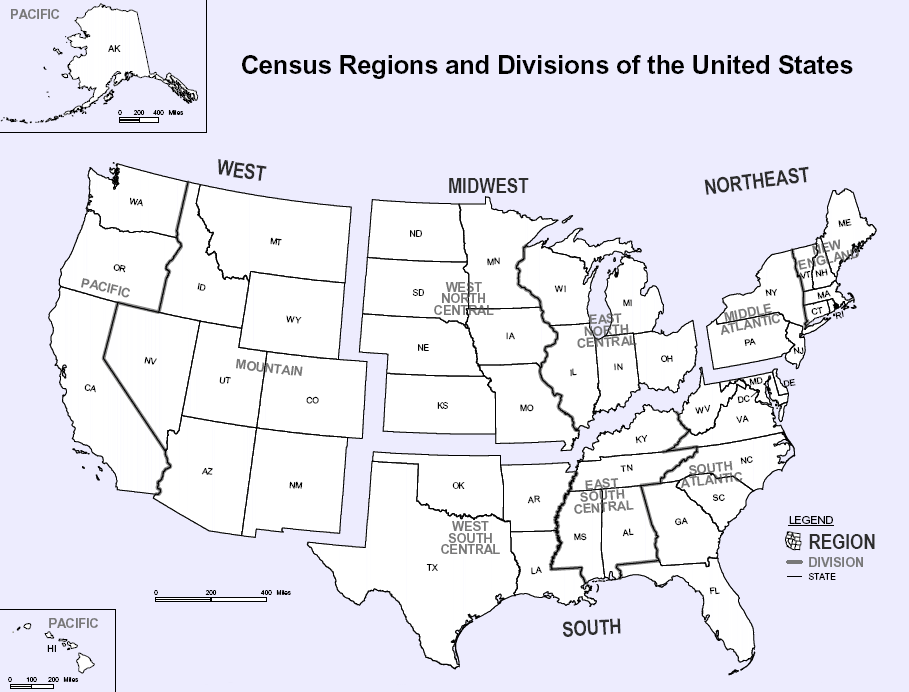

In [10]:
state_region_d = {
    'West' : ['Arizona', 'California', 'Colorado', 'Idaho', 'Montana', 'Nevada',  'New Mexico', 'Oregon',\
              'Utah',  'Washington'],
    'Midwest' : ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska',\
                 'North Dakota',  'Ohio', 'South Dakota', 'Wisconsin'],
    'Northeast' : ['Connecticut', 'Maine', 'Massachusetts',  'New Hampshire',  'New Jersey', 'New York',\
                   'Pennsylvania', 'Rhode Island', 'Vermont','Wyoming'],
    'South': ['Alabama', 'Arkansas', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Kentucky', \
              'Louisiana', 'Maryland', 'Mississippi',  'North Carolina', 'Oklahoma',  'South Carolina',\
              'Tennessee', 'Texas', 'Virginia', 'West Virginia'],
    'Pacific' : ['Hawaii', 'Alaska']
}

In [11]:
# Create a dictionary with {key=FIP: value=CountyName}
countyname_by_FIPS = dict(zip(county_xwalk['FIPS'], county_xwalk['CountyName']))

# Create a dictionary with {key=FIP: value=StateName}
statename_by_FIPS = dict(zip(county_xwalk['FIPS'], county_xwalk['StateName']))

# Create a dictionary with {key=FIP: value=MetroName_Zillow}
metroname_by_FIPS = dict(zip(county_xwalk['FIPS'], county_xwalk['MetroName_Zillow']))

In [12]:
county_ts.head(3)

,Date,RegionName,DaysOnZillow_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
0,1996-04-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65600.0,NaN,85700.0,86000.0,129700.0,NaN,NaN,NaN,NaN,NaN
1,1996-04-30,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81900.0,NaN,116800.0,116900.0,181400.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70600.0,NaN,110600.0,106800.0,192300.0,NaN,NaN,NaN,NaN,NaN


In [13]:
# Use the `countyname_by_FIPS` dictionary to impute a new column in the `county_ts` DataFrame

countyName_column = []
stateName_column = []
metroName_column = []

for row in county_ts.itertuples():
    # row.RegionName == crosswalk table's FIPS
    if row.RegionName in countyname_by_FIPS:
        countyName_column.append(countyname_by_FIPS[row.RegionName])
        stateName_column.append(statename_by_FIPS[row.RegionName])
        metroName_column.append(metroname_by_FIPS[row.RegionName])
    else:
        countyName_column.append(np.nan)
        
assert len(countyName_column) == len(county_ts) == len(stateName_column) == len(metroName_column)

county_ts['CountyName'] = countyName_column
county_ts['StateName'] = stateName_column
county_ts['MetroName'] = metroName_column

# Attach the region name to the respective counties

census_region_column = []
for row in county_ts.itertuples():
    for region, states in state_region_d.items():
        if row.StateName in states:
            census_region_column.append(region)
        else:
            pass
    
assert len(census_region_column) == len(county_ts), 'rework the for-loop'
county_ts['CensusRegion'] = census_region_column        


county_ts[['RegionName', 'CountyName', 'StateName', 'MetroName', 'CensusRegion']].head(3)

,RegionName,CountyName,StateName,MetroName,CensusRegion
0,10001,Kent,Delaware,"Dover, DE",South
1,10003,New Castle,Delaware,"Philadelphia, PA",South
2,1003,Baldwin,Alabama,"Daphne, AL",South


In [14]:
county_ts.to_pickle('../data/interim/county-time-series-with-fipsmap.pickle')

In [15]:
fips_county_metro_state_df = county_ts[['RegionName', 'CountyName', 'MetroName', 'StateName', 'CensusRegion']]
display(fips_county_metro_state_df.head(3))

fips_county_metro_state_df = fips_county_metro_state_df.drop_duplicates()
fips_county_metro_state_df.reset_index(drop=True, inplace=True)
fips_county_metro_state_df.to_pickle('../data/interim/fips-county-metro-state-df.pickle')

,RegionName,CountyName,MetroName,StateName,CensusRegion
0,10001,Kent,"Dover, DE",Delaware,South
1,10003,New Castle,"Philadelphia, PA",Delaware,South
2,1003,Baldwin,"Daphne, AL",Alabama,South


In [16]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}


In [17]:
city_xwalk = pd.read_csv('../data/raw/unzipped/cities_crosswalk.csv/cities_crosswalk.csv')
city_xwalk.head(3)

,Unique_City_ID,City,County,State
0,oak_grovechristianky,Oak Grove,Christian,KY
1,jarvisburgcurritucknc,Jarvisburg,Currituck,NC
2,mcminnvilleyamhillor,McMinnville,Yamhill,OR


In [18]:
fips_county_metro_state_df['StateAbbrev'] = [us_state_abbrev[row.StateName] 
                                             for row in fips_county_metro_state_df.itertuples()]

In [19]:
fips_map = fips_county_metro_state_df.merge(city_xwalk, 
                                 left_on=['CountyName', 'StateAbbrev'], 
                                 right_on=['County', 'State'],
                                 how='left')

display(fips_map.head(3))
display(fips_map.shape)
display(fips_map.info())

,RegionName,CountyName,MetroName,StateName,CensusRegion,StateAbbrev,Unique_City_ID,City,County,State
0,10001,Kent,"Dover, DE",Delaware,South,DE,highland_acreskentde,Highland Acres,Kent,DE
1,10001,Kent,"Dover, DE",Delaware,South,DE,kentonkentde,Kenton,Kent,DE
2,10001,Kent,"Dover, DE",Delaware,South,DE,farmingtonkentde,Farmington,Kent,DE


(24561, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24561 entries, 0 to 24560
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RegionName      24561 non-null  int64 
 1   CountyName      24561 non-null  object
 2   MetroName       19546 non-null  object
 3   StateName       24561 non-null  object
 4   CensusRegion    24561 non-null  object
 5   StateAbbrev     24561 non-null  object
 6   Unique_City_ID  24423 non-null  object
 7   City            24423 non-null  object
 8   County          24423 non-null  object
 9   State           24423 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.1+ MB


None

#### Inspection to determine if we should focus in on certain regions. 
- 2,701 unique Regions with 1,614 unique County names (some repeat names for common names such as King)
- 907 unique Metropolitan Areas (as defined by Zillow)
- 51 unique States (including DC)



- RegionName count > CountyName count because County Names are **not unique**.
- MetroName - there are several counties that are not associated with a specific metro area. However, the metro areas holding the most county data records are: 
    1. Atlanta, GA
    - New York, NY
    - Washington DC
    - Minneapolis-St Paul, MN
    - Virginia Beach, VA
- The Census Regions are listed below in descending order for # of available records:
    1. 239.8K South
    2. 150.8K Midwest
    3. 70.5K West
    4. 54.7K Northeast
    5. 2.8K Pacific

**Based on the above listed regions, I recommend we move forward with narrowing the scope of our project to the Southern region of the United States**.

In [22]:
Counter(county_ts['CensusRegion']).most_common()[:10]

[('South', 239834),
 ('Midwest', 150828),
 ('West', 70536),
 ('Northeast', 54730),
 ('Pacific', 2863)]

In [23]:
Counter(county_ts['MetroName']).most_common()[:10]

[(nan, 132151),
 ('Atlanta, GA', 7074),
 ('New York, NY', 6503),
 ('Washington, DC', 5566),
 ('Minneapolis-St Paul, MN', 3989),
 ('Virginia Beach, VA', 3798),
 ('Nashville, TN', 3638),
 ('Richmond, VA', 3519),
 ('Chicago, IL', 3466),
 ('St. Louis, MO', 3389)]